In [1]:
%%capture
!pip install mlflow

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pyspark.sql.functions import mean, col
from random import random, randint
from urllib.request import urlretrieve

from mlflow import mlflow,log_metric, log_param, log_artifacts
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#mlflow.set_tracking_uri('http://mlflow:5000')

%reload_ext autoreload
%autoreload 2

In [3]:
#mlflow.end_run()
mlflow.set_experiment('Default')

In [4]:
with mlflow.start_run() as run:
    print("Running mlflow_tracking.py")

    log_param("param1", randint(0, 100))

    log_metric("foo", random())
    log_metric("foo", random() + 1)
    log_metric("foo", random() + 2)

    if not os.path.exists("outputs"):
        os.makedirs("outputs")
    with open("outputs/test.txt", "w") as f:
        f.write("hello world!")

    log_artifacts("outputs")

Running mlflow_tracking.py


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.\
        builder.\
        appName("mlflow-tracking").\
        master("local[*]").\
        config("spark.executor.memory", "2048m").\
        config("spark.jars.packages", "io.delta:delta-core_2.12:0.7.0"). \
        config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension"). \
        config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog"). \
        getOrCreate()

from delta.tables import *

In [6]:
%run ../includes/utilities.ipynb

In [7]:
process_file(
  "health_profile_data.snappy.parquet",
  silverDailyPath,
  "health_profile_data"
)
process_file(
  "user_profile_data.snappy.parquet",
  dimUserPath,
  "user_profile_data"
)

Retrieve health_profile_data.snappy.parquet.
Load health_profile_data.snappy.parquet to /home/jovyan/work/dsc402/lpalum/mlmodels/profile/daily/
Register health_profile_data using path: /home/jovyan/work/dsc402/lpalum/mlmodels/profile/daily/
Retrieve user_profile_data.snappy.parquet.
Load user_profile_data.snappy.parquet to /home/jovyan/work/dsc402/lpalum/mlmodels/profile/users/
Register user_profile_data using path: /home/jovyan/work/dsc402/lpalum/mlmodels/profile/users/


## Read the user and health profile data

In [8]:
user_profile_df = spark.read.table("user_profile_data")
health_profile_df = spark.read.table("health_profile_data")

## Generate a sample of the users

In [9]:
user_profile_sample_df = user_profile_df.sample(0.1)

user_profile_sample_df.groupby("lifestyle").count().show()

+--------------+-----+
|     lifestyle|count|
+--------------+-----+
|     sedentary|   98|
|weight trainer|   95|
|cardio trainer|  106|
+--------------+-----+



In [9]:
# TODO Join the user profile sample with the health data
health_profile_sample_df = (
  user_profile_sample_df
  .join(health_profile_df, "_id")
)

assert 365*user_profile_sample_df.count() == health_profile_sample_df.count()

In [10]:
health_profile_sample_df.show(n=2)

+--------------------+-----------+---------+--------------+------+-------+-------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+
|                 _id| first_name|last_name|     lifestyle|female|country|   occupation|                dte| resting_heartrate| active_heartrate|               BMI|          VO2_max|   workout_minutes|
+--------------------+-----------+---------+--------------+------+-------+-------------+-------------------+------------------+-----------------+------------------+-----------------+------------------+
|d2a5908c-e48a-11e...|Christopher|Rodriguez|weight trainer| false|    BRA|Other-service|2019-01-01 00:00:00|   59.049999278806|99.06292510735334| 24.38539239429579|35.31970226363891|29.392831292332602|
|d2a5908c-e48a-11e...|Christopher|Rodriguez|weight trainer| false|    BRA|Other-service|2019-01-02 00:00:00|46.036121766915294|98.37158794894626|24.897149008292878|35.21396047076472|22.2976995

In [11]:
from pyspark.sql.functions import mean, col

health_tracker_sample_agg_df = (
    health_profile_sample_df.groupBy("_id")
    .agg(
        mean("BMI").alias("mean_BMI"),
        mean("active_heartrate").alias("mean_active_heartrate"),
        mean("resting_heartrate").alias("mean_resting_heartrate"),
        mean("VO2_max").alias("mean_VO2_max"),
        mean("workout_minutes").alias("mean_workout_minutes")
    )
)

In [12]:
health_tracker_sample_agg_df.show(n=2)

+--------------------+------------------+---------------------+----------------------+-----------------+--------------------+
|                 _id|          mean_BMI|mean_active_heartrate|mean_resting_heartrate|     mean_VO2_max|mean_workout_minutes|
+--------------------+------------------+---------------------+----------------------+-----------------+--------------------+
|da506960-e48a-11e...|26.120222884635204|   118.93575808039463|    59.130983394235344|33.70817172843563|   27.69988308853618|
|d8251d0c-e48a-11e...|24.449035175509568|   117.92057791367135|      59.3180284743097|34.19192318617704|    28.5192912127726|
+--------------------+------------------+---------------------+----------------------+-----------------+--------------------+
only showing top 2 rows



In [13]:
health_tracker_augmented_df = (
  health_tracker_sample_agg_df
  .join(user_profile_df, "_id")
)

In [14]:
health_tracker_augmented_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- mean_BMI: double (nullable = true)
 |-- mean_active_heartrate: double (nullable = true)
 |-- mean_resting_heartrate: double (nullable = true)
 |-- mean_VO2_max: double (nullable = true)
 |-- mean_workout_minutes: double (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- lifestyle: string (nullable = true)
 |-- female: boolean (nullable = true)
 |-- country: string (nullable = true)
 |-- occupation: string (nullable = true)



In [15]:
from pyspark.sql.types import _parse_datatype_string

augmented_schema = """
  mean_BMI double,
  mean_active_heartrate double,
  mean_resting_heartrate double,
  mean_VO2_max double,
  mean_workout_minutes double,
  female boolean,
  country string,
  occupation string,
  lifestyle string
"""

health_tracker_augmented_df = (health_tracker_augmented_df.select(["mean_BMI",
                                                                   "mean_active_heartrate",
                                                                   "mean_resting_heartrate",
                                                                   "mean_VO2_max",
                                                                   "mean_workout_minutes",
                                                                   "female",
                                                                   "country",
                                                                   "occupation",
                                                                   "lifestyle"
                                                                  ]))



assert health_tracker_augmented_df.schema == _parse_datatype_string(augmented_schema)

In [16]:
health_tracker_augmented_df.show()

+------------------+---------------------+----------------------+------------------+--------------------+------+-------+-----------------+--------------+
|          mean_BMI|mean_active_heartrate|mean_resting_heartrate|      mean_VO2_max|mean_workout_minutes|female|country|       occupation|     lifestyle|
+------------------+---------------------+----------------------+------------------+--------------------+------+-------+-----------------+--------------+
|26.120222884635204|   118.93575808039463|    59.130983394235344| 33.70817172843563|   27.69988308853618| false|    BRA|  Priv-house-serv|weight trainer|
|24.449035175509568|   117.92057791367135|      59.3180284743097| 34.19192318617704|    28.5192912127726| false|    USA|     Craft-repair|weight trainer|
|20.333683745375815|   100.32251622502783|     51.03912772943997|39.853055182561214|  26.642748895487937|  true|    USA|Handlers-cleaners|cardio trainer|
|23.216265706245466|   135.18084653590242|     79.62226987115773|22.25804789

## Write the augmented data to the delta table

In [17]:
(
  health_tracker_augmented_df.write
  .format("delta")
  .mode("overwrite")
  .save(goldPath + "health_tracker_augmented")
)

## Read the augmented (gold) data from the delata lake

In [18]:
health_tracker_augmented_df = (
  spark.read
  .format("delta")
  .load(goldPath + "health_tracker_augmented")
  .toPandas()
)

In [19]:
lifestyles = health_tracker_augmented_df.lifestyle.unique()
lifestyles

array(['weight trainer', 'cardio trainer', 'sedentary'], dtype=object)

In [20]:
features = health_tracker_augmented_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_df[["lifestyle"]].copy()

In [21]:
features.sample(10)

,mean_BMI,mean_active_heartrate,mean_resting_heartrate,mean_VO2_max,mean_workout_minutes,female,country,occupation
265,21.273469,123.192124,56.597801,37.233603,28.184180,True,USA,Other-service
284,17.265603,131.762871,87.958959,17.464332,8.669034,False,NZL,Craft-repair
281,28.923030,93.950564,46.349994,46.459972,26.783775,False,USA,Craft-repair
258,28.033483,136.347056,66.924891,30.060121,8.669997,False,ITA,Farming-fishing
202,25.828315,105.708324,48.266766,43.390750,25.551615,True,USA,Adm-clerical
289,27.754408,138.130379,68.904919,28.648135,8.241829,True,USA,Sales
271,21.778562,128.264789,57.098417,37.107227,25.715998,False,GHA,Sales
193,31.508693,127.872107,61.611030,32.570444,8.420192,True,BRA,Machine-op-inspct
133,22.762299,105.689760,49.167710,41.888368,25.715299,False,USA,Protective-serv
147,26.884876,121.278561,61.810169,31.132022,25.981131,True,USA,Machine-op-inspct


In [22]:
features.dtypes

mean_BMI                  float64
mean_active_heartrate     float64
mean_resting_heartrate    float64
mean_VO2_max              float64
mean_workout_minutes      float64
female                       bool
country                    object
occupation                 object
dtype: object

In [23]:
features_numerical = features.select_dtypes(include=[float])
features_categorical = features.select_dtypes(exclude=[float])

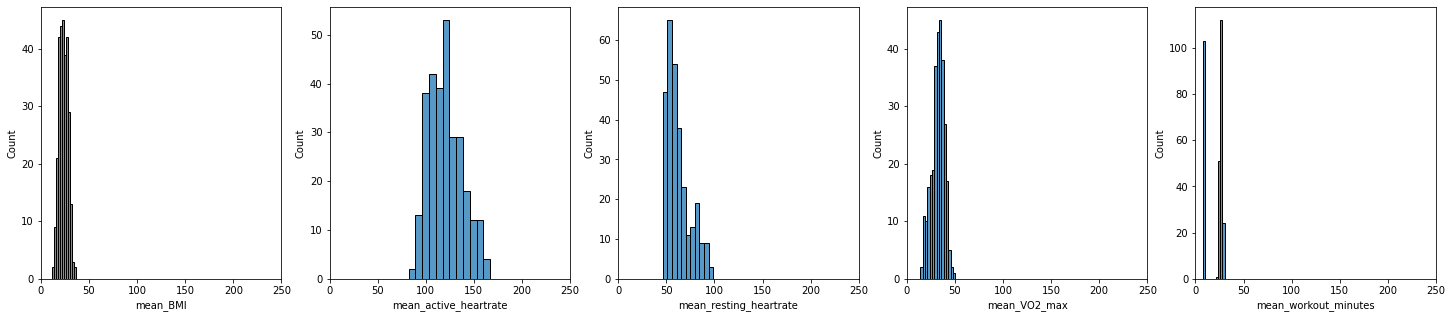

In [24]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  sns.histplot(features[feature], ax=ax[i])
  ax[i].set_xlim(0,250)

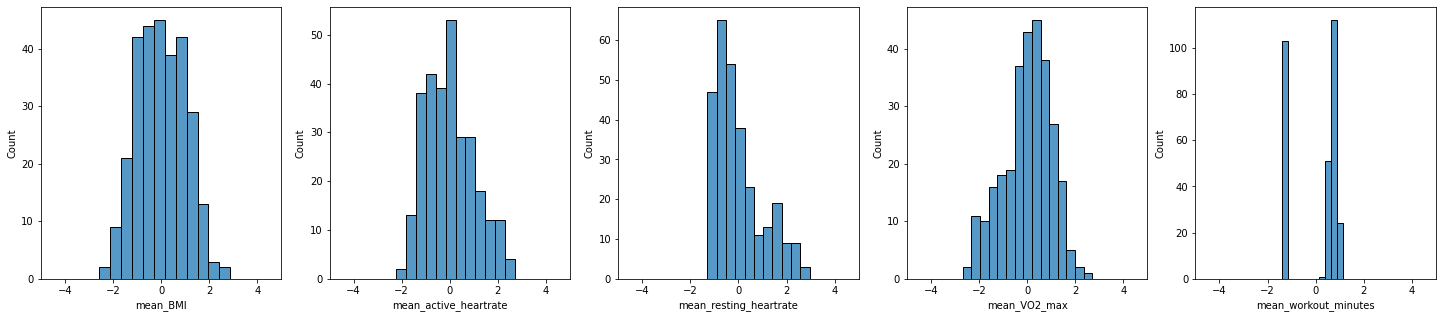

In [25]:
fig, ax = plt.subplots(1,5, figsize=(25,5))

for i, feature in enumerate(features_numerical):
  feature_series = features[feature]
  feature_scaled = (feature_series - feature_series.mean())/feature_series.std()
  sns.histplot(feature_scaled, ax=ax[i])
  ax[i].set_xlim(-5, 5)

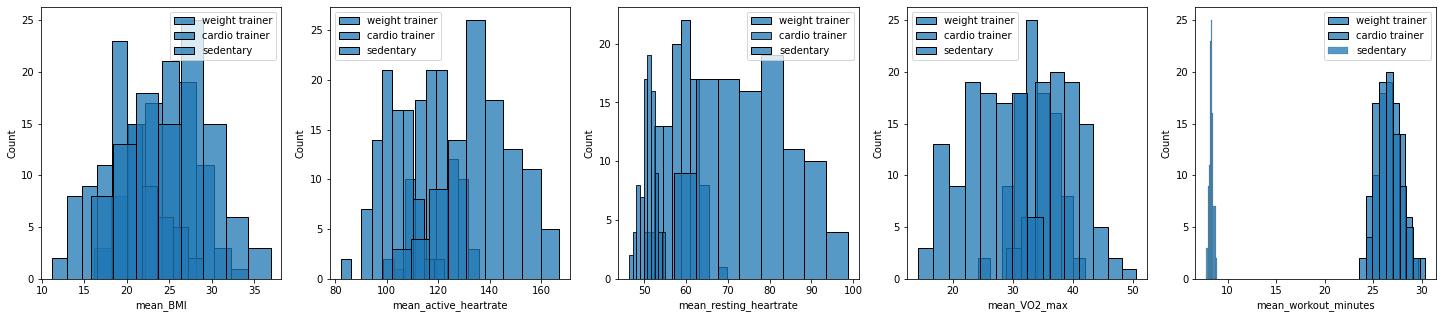

In [26]:
fig, ax = plt.subplots(1,5, figsize=(25,5))
for i, feature in enumerate(features_numerical):
  for lifestyle in lifestyles:
    subset = features[target["lifestyle"] == lifestyle]
    sns.histplot(subset[feature], ax=ax[i], label=lifestyle)
  ax[i].legend()

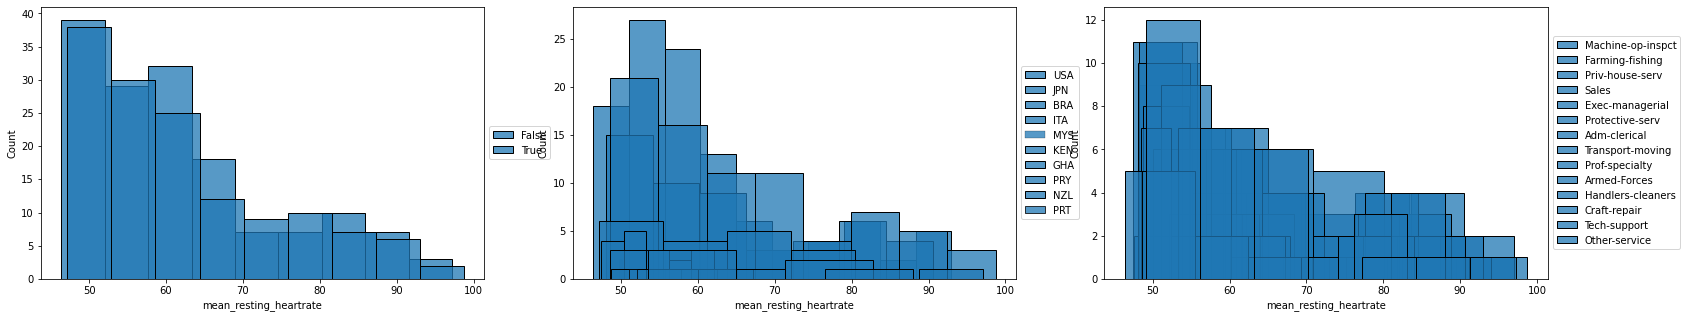

In [27]:
fig, ax = plt.subplots(1,3, figsize=(27,5))

for i, feature in enumerate(features_categorical):
  for value in features[feature].unique():
    subset = features[features[feature] == value]
    sns.histplot(subset["mean_resting_heartrate"], ax=ax[i], label=value)
  ax[i].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

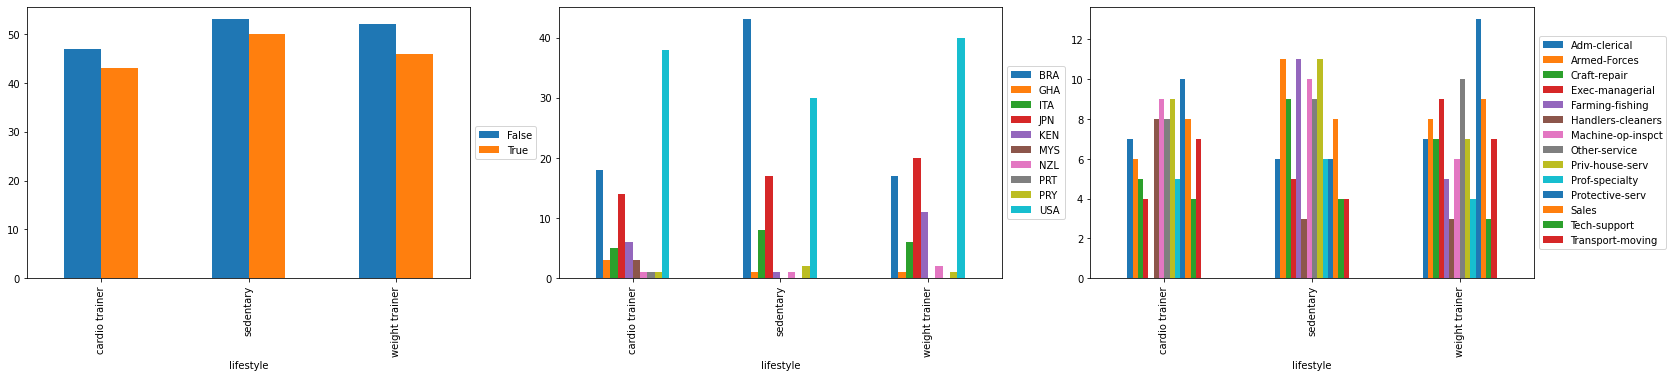

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(27,5))
(
  health_tracker_augmented_df
  .groupby("female")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[0]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("country")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[1]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)
(
  health_tracker_augmented_df
  .groupby("occupation")
  .lifestyle.value_counts()
  .unstack(0)
  .plot(kind="bar", ax=ax[2]).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
)

In [29]:
pd.get_dummies(features_categorical)

,female,country_BRA,country_GHA,country_ITA,country_JPN,country_KEN,country_MYS,country_NZL,country_PRT,country_PRY,...,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving
0,False,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,True,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,False,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,False,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,True,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
288,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')
ohe.fit_transform(features_categorical)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

# Building a Linear Customer Classfication Model

In [31]:
from sklearn.preprocessing import LabelEncoder

features = health_tracker_augmented_df.drop("lifestyle", axis=1)
target = health_tracker_augmented_df["lifestyle"]
le = LabelEncoder()
target = le.fit_transform(target)

In [32]:
# Perform Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target)

In [33]:
# Split Data into Numerical and Categorical Sets
X_train_numerical = X_train.select_dtypes(exclude=["object"])
X_test_numerical = X_test.select_dtypes(exclude=["object"])
X_train_categorical = X_train.select_dtypes(include=["object"])
X_test_categorical = X_test.select_dtypes(include=["object"])

In [34]:
ss = StandardScaler()
ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

# Create One-Hot Encoded Categorical DataFrames
X_train_ohe = pd.DataFrame(
  ohe.fit_transform(X_train_categorical),
  columns=ohe.get_feature_names(),
  index=X_train_numerical.index
)
X_test_ohe = pd.DataFrame(
  ohe.transform(X_test_categorical),
  columns=ohe.get_feature_names(),
  index=X_test_numerical.index
)

In [35]:
# Merge Numerical and One-Hot Encoded Categorical
X_train = X_train_numerical.merge(X_train_ohe, left_index=True, right_index=True)
X_test = X_test_numerical.merge(X_test_ohe, left_index=True, right_index=True)

In [36]:
# Standardize Data
X_train = pd.DataFrame(
  ss.fit_transform(X_train),
  index=X_train_ohe.index,
  columns=X_train.columns)
X_test = pd.DataFrame(
  ss.transform(X_test),
  index=X_test_ohe.index,
  columns=X_train.columns)

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
data = (X_train, X_test, y_train, y_test)

Grid-Searched Model Fitting
The following models were fit using a grid-searched, cross validation with the respective parameter dictionaries:

Ridge,
{'alpha' : logspace(-5,5,11)}
Lasso,
{'alpha' : logspace(-5,5,11)}
Elastic Net,
{'alpha' : logspace(-5,5,11), 'l1_ratio' : linspace(0,1,11)}

In [39]:
try:
    experiment_id = mlflow.create_experiment('heath-lifestyle-classification-modeling')
except:
    print("experiment already created")
    experiment_id = mlflow.get_experiment_by_name('heath-lifestyle-classification-modeling').experiment_id

experiment already created


In [40]:
print(experiment_id)

1


In [41]:
from dsas.experiment import mlflow_run, prepare_coefs, prepare_results

In [42]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l2']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [43]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['l1'], "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [44]:
estimator = LogisticRegression(max_iter=10000)
param_grid = {
  'C' : np.logspace(-5,5,11),
  "penalty" : ['elasticnet'],
  'l1_ratio' : np.linspace(0,1,11),
  "solver" : ['saga']
}
mlflow_run(experiment_id, estimator, param_grid, data)

In [45]:
experiments = prepare_results(experiment_id)
experiments.head()

,artifact_uri,metrics.train acc,metrics.test acc,params.penalty,params.C,params.solver,params.l1_ratio,params.model
0,s3://mlflow/1/cfd6f5b22cf746988d6038cac50ec714...,1.0,0.958904,elasticnet,10.0,saga,1.0,LogisticRegression
1,s3://mlflow/1/e8da258e99f94dfdbf4b1cdbe7d931dc...,1.0,0.958904,l1,10.0,saga,None,LogisticRegression
2,s3://mlflow/1/20042af9e8d64cf5854580fa3778faa5...,1.0,0.958904,l2,1000.0,None,None,LogisticRegression
3,s3://mlflow/1/62d7cd80db724c4fb7690cd7622802b9...,1.0,1.000000,elasticnet,10.0,saga,1.0,LogisticRegression
4,s3://mlflow/1/fff2fb6baf1540559fdff5b099573de7...,1.0,1.000000,l1,10.0,saga,None,LogisticRegression


/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jovyan/work/dsas/experiment.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax = coefs.T.plot(figsize=(20,7))
<ipython-input-46-2376f7c1249a>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  prepare_coefs(experiments, le.classes_, X_train.columns)


(                                            mean_BMI  mean_active_heartrate  \
 C       l1_ratio penalty    lifestyle                                         
 10.0    1.0      elasticnet cardio trainer -0.898897              -4.650846   
                             sedentary       0.000000               1.285652   
                             weight trainer  0.000000               0.521584   
         NaN      l1         cardio trainer -0.898740              -4.654596   
                             sedentary       0.000000               1.284641   
                             weight trainer  0.000000               0.518434   
 1000.0  NaN      l2         cardio trainer -1.424470              -9.719829   
                             sedentary       0.393611               5.109771   
                             weight trainer  1.030859               4.610058   
 10.0    1.0      elasticnet cardio trainer -1.865454              -2.874966   
                             sedentary  

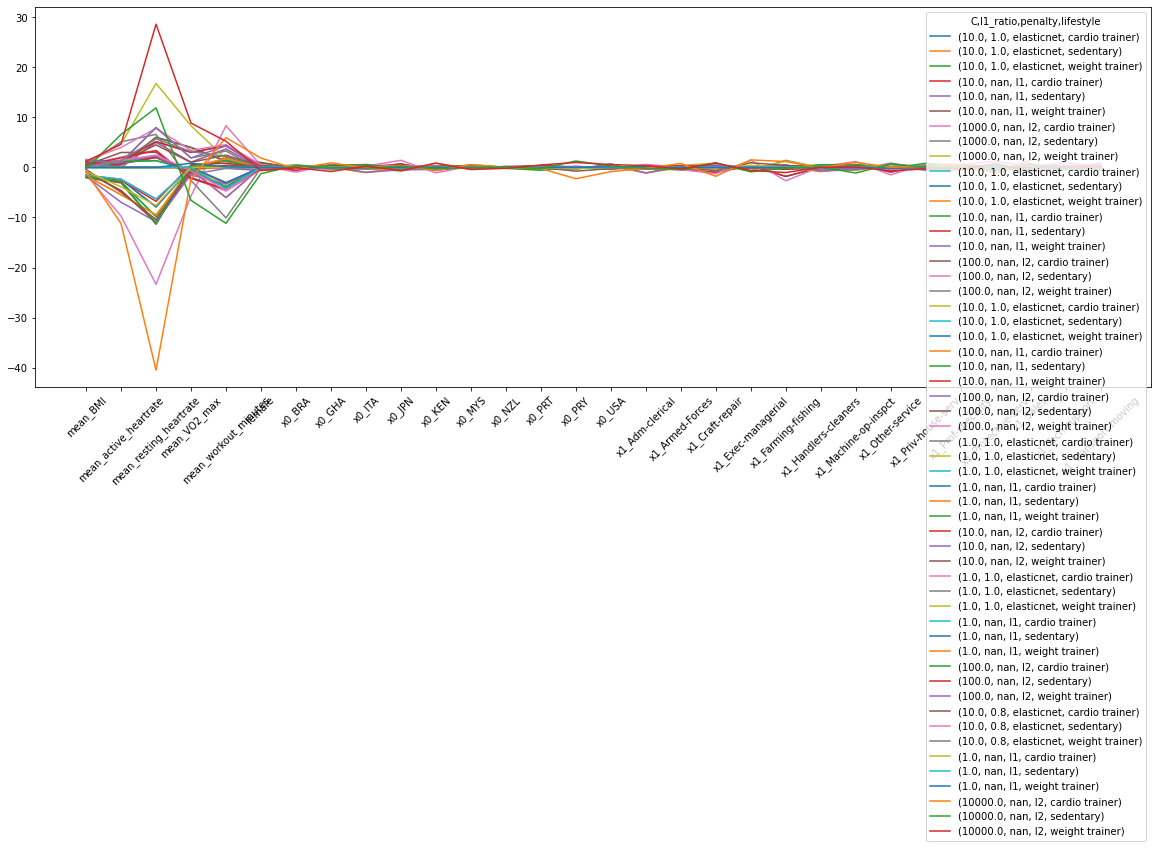

In [46]:
prepare_coefs(experiments, le.classes_, X_train.columns)

In [47]:
spark.stop()